<a href="https://colab.research.google.com/github/ozzmanmuhammad/Audio-Classification/blob/main/AudioClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import and install Dependencies

In [2]:
!pip install tensorflow.io

     |████████████████████████████████| 23.4 MB 1.5 MB/s 


In [3]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_io as tfio
from IPython import display

In [4]:
!wget https://raw.githubusercontent.com/ozzmanmuhammad/Extras/main/DL_Extras/helperFunctions.py

--2022-05-02 05:14:29--  https://raw.githubusercontent.com/ozzmanmuhammad/Extras/main/DL_Extras/helperFunctions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helperFunctions.py’

helperFunctions.py  100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-02 05:14:29 (110 MB/s) - ‘helperFunctions.py’ saved [10246/10246]



In [57]:
from helperFunctions import unzip_data, plot_loss_curves

In [6]:
# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# 2. Downloading and extracting Dataset from Kaggle

## 2.1 Downloading Dataset

In [7]:
!pip install kaggle

In [8]:
!rm -r ~/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


In [9]:
!mkdir ~/.kaggle

In [10]:
!mv ./kaggle.json ~/.kaggle/

In [11]:
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle datasets list

ref                                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/muratkokludataset/date-fruit-datasets                                 Date Fruit Datasets                              408KB  2022-04-03 09:25:39           3878        673  0.9375           
datasets/muratkokludataset/acoustic-extinguisher-fire-dataset                  Acoustic Extinguisher Fire Dataset               621KB  2022-04-02 22:59:36            581        598  0.9375           
datasets/muratkokludataset/pistachio-dataset                                   Pistachio Dataset                                  2MB  2022-04-03 08:38:21            377        527  0.9375           


In [13]:
!kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing

100% 601M/604M [00:14<00:00, 41.9MB/s]
100% 604M/604M [00:14<00:00, 44.7MB/s]


In [14]:
os.rename("z-by-hp-unlocked-challenge-3-signal-processing.zip","data.zip")

## 2.2 Extracting Dataset

In [15]:
unzip_data("data.zip")

# 3. Building data loading functions

## 3.1 Define Paths to Files

In [16]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC114131-2.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'Crickets-chirping-0.wav')

## 3.2 Building dataloading function

In [17]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 3.3 Ploting single example

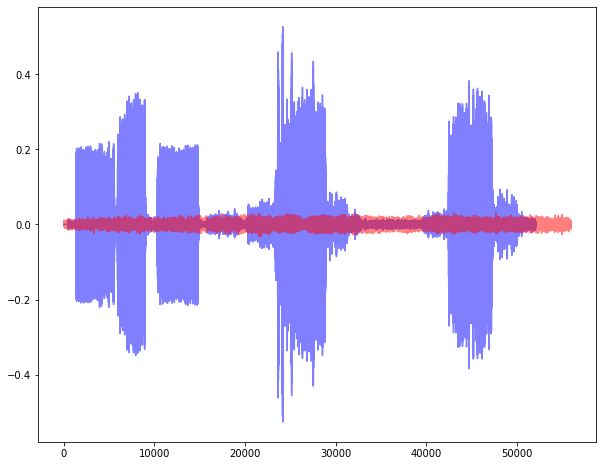

In [18]:
plt.figure(figsize = (10, 8))
plt.plot(load_wav_16k_mono(NOT_CAPUCHIN_FILE), alpha = 0.5, c = "b")
plt.plot(load_wav_16k_mono(CAPUCHIN_FILE), alpha = 0.5, c = "r")
plt.show()

# 4. Tensorflow Datasets

## 4.1 Creating Dataset

In [19]:
POS = tf.data.Dataset.list_files(
    os.path.join("data", "Parsed_Capuchinbird_Clips")+'/*.wav'
    )
NEG = tf.data.Dataset.list_files(
    os.path.join("data", "Parsed_Not_Capuchinbird_Clips")+'/*.wav'
    )

## 4.2 Adding Labels and combining into single data

In [20]:
POS = tf.data.Dataset.zip((POS, tf.data.Dataset.from_tensor_slices(tf.ones(len(POS)))))
NEG = tf.data.Dataset.zip((NEG, tf.data.Dataset.from_tensor_slices(tf.zeros(len(NEG)))))

In [21]:
POS.as_numpy_iterator().next(), NEG.as_numpy_iterator().next()

((b'data/Parsed_Capuchinbird_Clips/XC22397-6.wav', 1.0),
 (b'data/Parsed_Not_Capuchinbird_Clips/sparrow-sound-effect-14.wav', 0.0))

## 4.3 Let's plot a few audio waveforms with labels

In [22]:
def plot_wave(file_path, title = "None"):
  rows = 3
  cols = 3
  n = rows * cols
  fig, axes = plt.subplots(rows, cols, figsize=(16, 12))

  for i, (audio, label) in enumerate(file_path.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(load_wav_16k_mono(audio.numpy()))
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    ax.set_title(label.numpy())

  plt.title(title)
  plt.show()

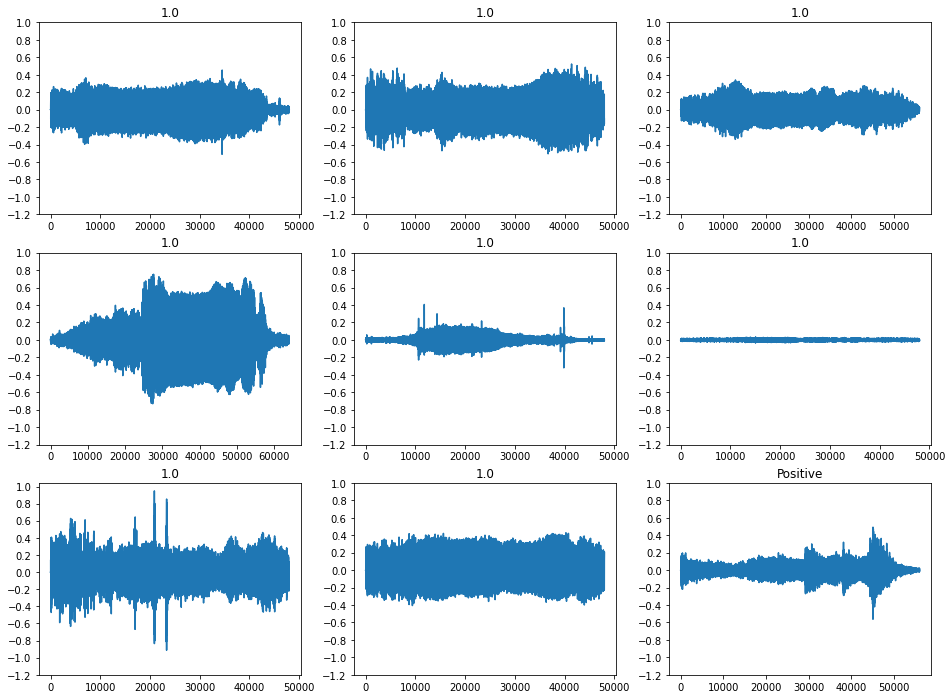

In [23]:
# Capuchinbrid 
plot_wave(POS, title = "Positive")

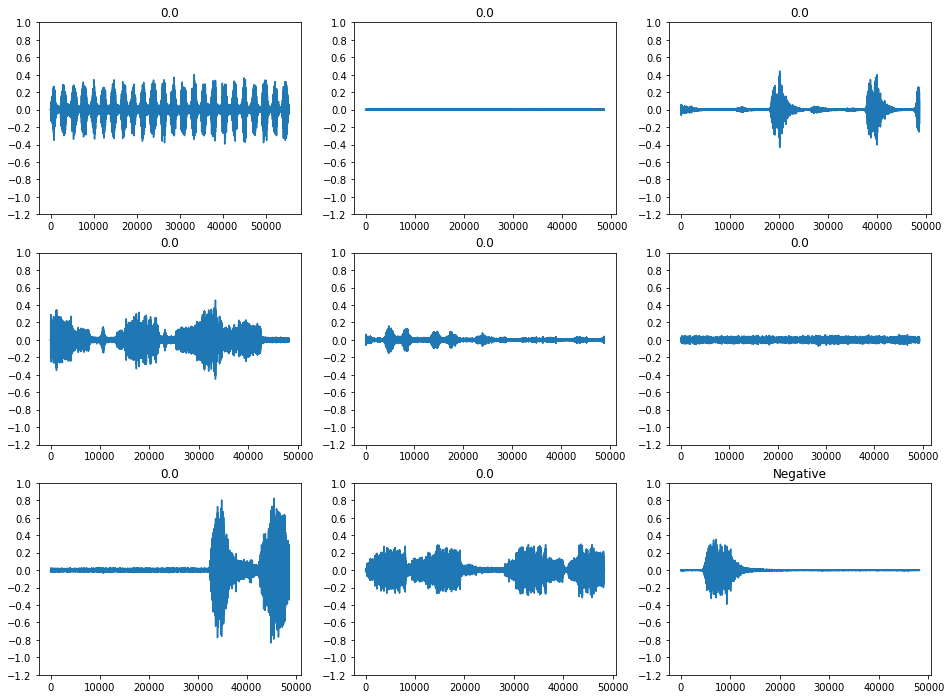

In [24]:
# Not Capuchinbrid 
plot_wave(NEG, title = "Negative")

## 4.4 Concatenating into single data

In [25]:
data = POS.concatenate(NEG)

# 5. EDA of Capuchin Call

In [26]:
CAPUCHIN_FILES = tf.data.Dataset.list_files(
    os.path.join("data", "Parsed_Capuchinbird_Clips")+'/*.wav'
    )
lengths =  [len(file) for file in CAPUCHIN_FILES.map(load_wav_16k_mono, tf.data.AUTOTUNE)]

In [27]:
df = pd.DataFrame(lengths, columns = ["Lengths"])

In [28]:
df.Lengths.describe()

count      217.000000
mean     54156.663594
std       8191.767002
min      32000.000000
25%      48000.000000
50%      56000.000000
75%      56000.000000
max      80000.000000
Name: Lengths, dtype: float64

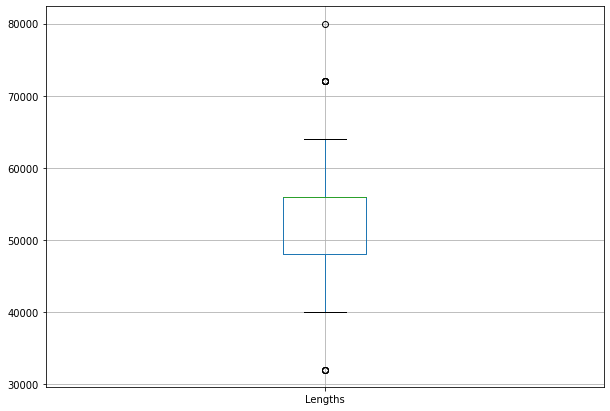

In [29]:
df.boxplot(column=['Lengths'], figsize=(10,7))

NOTE: *Choosing 48000 max length* as this will cover majority of the wav files and will also have less parameters during training.

# 6. Converting to Spectrums

In [30]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 6.1 Testing the ftn

In [31]:
for waveform_file, label in data.take(1):
  print(waveform_file)
  label = label.numpy()
  wav = load_wav_16k_mono(waveform_file)
  spectrogram = preprocess(waveform_file, label)[0]

tf.Tensor(b'data/Parsed_Capuchinbird_Clips/XC526106-2.wav', shape=(), dtype=string)


In [32]:
print('Waveform shape:', wav.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(wav, rate=16000))

Waveform shape: (56000,)
Spectrogram shape: (1491, 257, 1)
Audio playback


## 6.2 Ploting Spectrogram

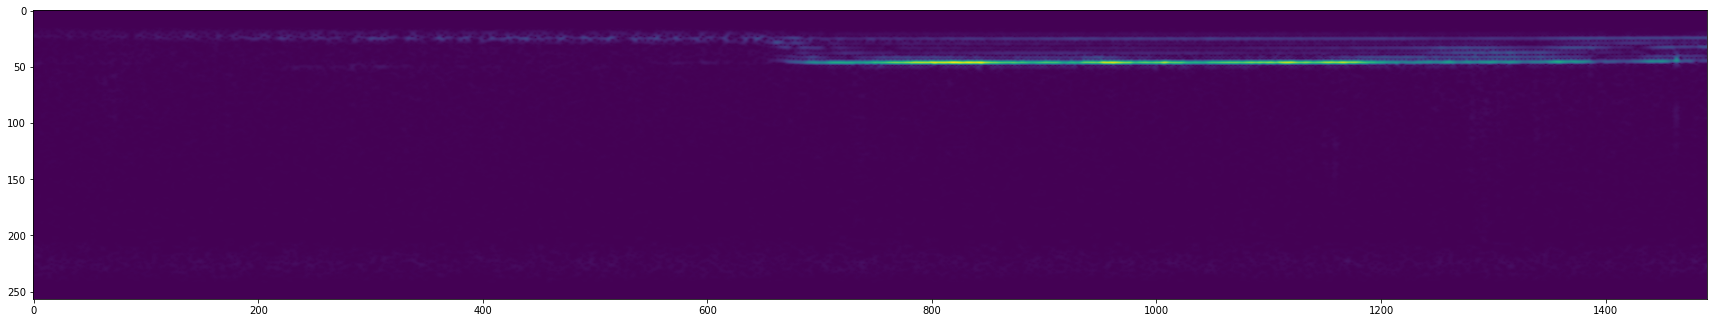

In [33]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [34]:
#a function for displaying a spectrogram:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

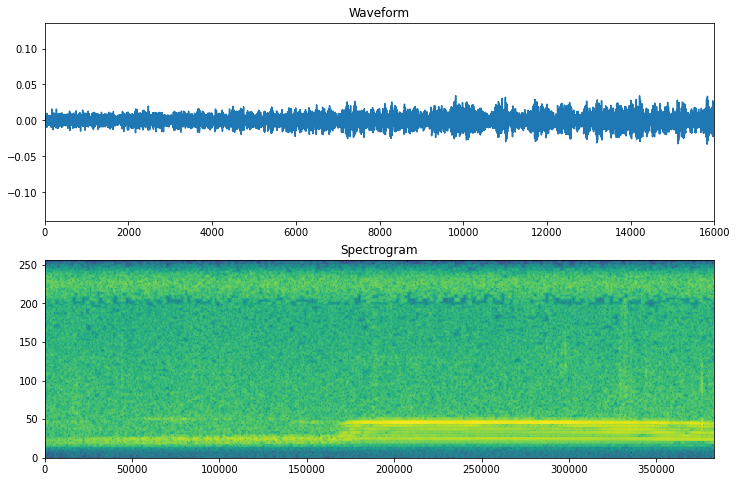

In [35]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(wav.shape[0])
axes[0].plot(timescale, wav.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

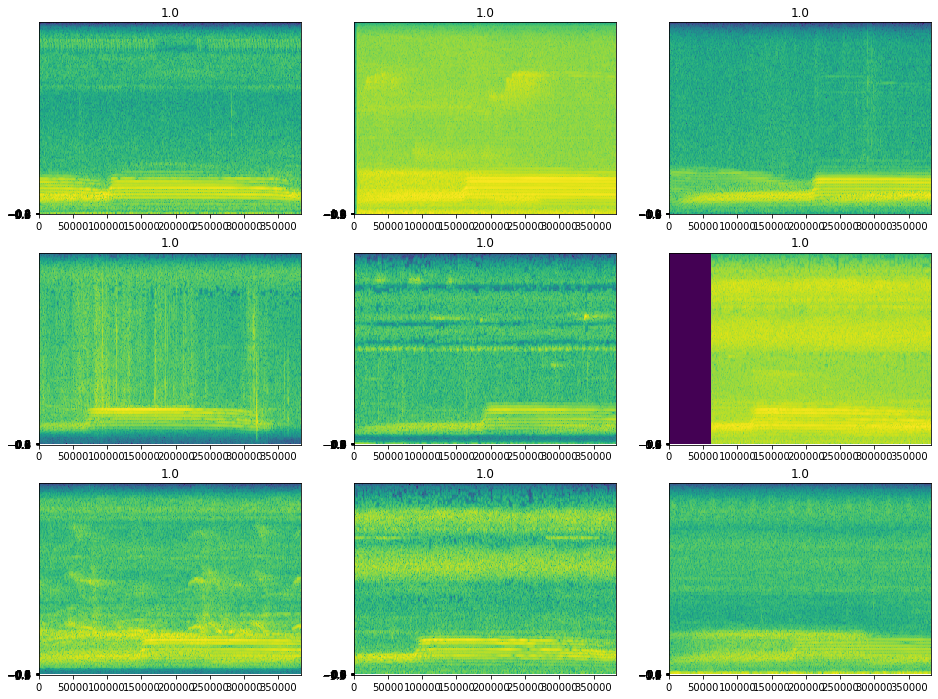

In [36]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))

for i, (audio, label) in enumerate(data.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  spectrogram = preprocess(audio, label)[0]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  ax.set_title(label.numpy())

plt.show()

# 7. Training and Testing datatsets

In [37]:
data = data.map(preprocess).cache().shuffle(buffer_size=1000).batch(16).prefetch(tf.data.AUTOTUNE)

In [38]:
len(data)*.7 # 70% training and 30% testing

35.699999999999996

In [39]:
train = data.take(36)
test = data.skip(36).take(15)

# 8. Building DL Model

In [46]:
!nvidia-smi

Mon May  2 05:24:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    27W /  70W |  14106MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

NOTE: To create following model with input shape of 

```
shape=(1491, 257,1)
```
This will have following parameters

```
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
```


You have to use T4 GPU or above other wise you'll get OOM error.

You can also do following to reduce the parameters:


1.   layers.Resizing(32, 32),
2.   layers.Normalization()

Resizing layer will reduce your parameters significantly and will also effect the models accuracy.



In [52]:

model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(1491, 257,1)),

        tf.keras.layers.Conv2D(16, (3,3), activation = "relu"),
        tf.keras.layers.MaxPooling2D(), # to reduce 7M parameters
        tf.keras.layers.Conv2D(16, (3,3), activation = "relu"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation = "relu"),
        tf.keras.layers.Dense(1, activation = "sigmoid"),
])

In [53]:
model.compile(loss = 'BinaryCrossentropy', 
              optimizer = tf.keras.optimizers.Adam(),
              metrics = [tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])


In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 744, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 flatten_2 (Flatten)         (None, 1484000)           0         
                                                                 
 dense_4 (Dense)             (None, 128)               189952128 
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                      

## 8.1 Training the model

In [56]:
history = model.fit(train,
                    epochs = 6,
                    validation_data = test) # as data quantity was not significant

Epoch 1/6
36/36 [==============================] - 8s 218ms/step - loss: 0.0136 - recall_3: 0.9933 - precision_3: 0.9933 - val_loss: 0.0172 - val_recall_3: 1.0000 - val_precision_3: 0.9844
Epoch 2/6
36/36 [==============================] - 7s 202ms/step - loss: 0.0027 - recall_3: 1.0000 - precision_3: 1.0000 - val_loss: 5.1140e-04 - val_recall_3: 1.0000 - val_precision_3: 1.0000
Epoch 3/6
36/36 [==============================] - 7s 202ms/step - loss: 2.2028e-04 - recall_3: 1.0000 - precision_3: 1.0000 - val_loss: 3.0581e-04 - val_recall_3: 1.0000 - val_precision_3: 1.0000
Epoch 4/6
36/36 [==============================] - 7s 203ms/step - loss: 2.4721e-04 - recall_3: 1.0000 - precision_3: 1.0000 - val_loss: 1.8296e-04 - val_recall_3: 1.0000 - val_precision_3: 1.0000
Epoch 5/6
36/36 [==============================] - 7s 202ms/step - loss: 6.8449e-04 - recall_3: 1.0000 - precision_3: 1.0000 - val_loss: 1.6278e-04 - val_recall_3: 1.0000 - val_precision_3: 1.0000
Epoch 6/6
36/36 [==========

In [61]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  recall = history.history['recall_3']
  val_recall = history.history['val_recall_3']

  precision = history.history['precision_3']
  val_precision = history.history['val_precision_3']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot Recall
  plt.figure()
  plt.plot(epochs, recall, label='training_recall')
  plt.plot(epochs, val_recall, label='val_recall')
  plt.title('Recall')
  plt.xlabel('Epochs')
  plt.legend();

  # Plot Precision
  plt.figure()
  plt.plot(epochs, precision, label='training_precision')
  plt.plot(epochs, val_precision, label='val_precision')
  plt.title('Precision')
  plt.xlabel('Epochs')
  plt.legend();


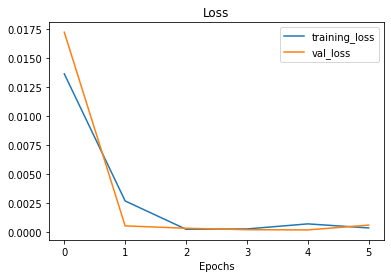

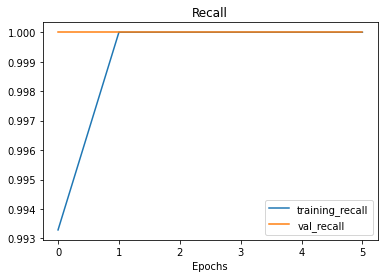

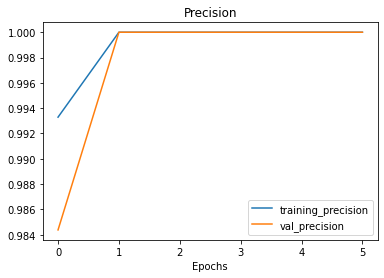

In [62]:
plot_loss_curves(history)

NOTE: **Model is producing recall and precision of 1 which is the highest, we have to verify that in future and its not overfitting the data**

## 8.2 Saving the trained model into the drive

In [69]:
!mkdir /content/drive/MyDrive/Saved_Models/AudioClassification

In [70]:
Path = "/content/drive/MyDrive/Saved_Models/AudioClassification"
model.save(Path) 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Saved_Models/AudioClassification/assets


In [ ]:
# new_model = tf.keras.models.load_model(Path)

# Check its architecture
# new_model.summary()

# 9 Making Predictions and Evaluation

## 9.1 Making prediction on test data

In [95]:
model.evaluate(test)

15/15 [==============================] - 1s 44ms/step - loss: 1.9780e-04 - recall_3: 1.0000 - precision_3: 1.0000


[0.00019779933791141957, 1.0, 1.0]

### 9.1.1 Unpacking tf.dataset to get a single batch

In [97]:
X_test, y_true = test.as_numpy_iterator().next()

In [98]:
y_pred = model.predict(X_test)

In [100]:
y_pred

array([[1.8353723e-13],
       [9.6893429e-15],
       [1.5842565e-08],
       [9.9997950e-01],
       [7.8994563e-05],
       [2.7422782e-06],
       [8.2950926e-14],
       [3.0757921e-10],
       [9.7819648e-05],
       [1.0481968e-04],
       [8.4614298e-13],
       [7.4090023e-10],
       [9.9968243e-01],
       [1.0000000e+00],
       [4.2663130e-05],
       [2.2745043e-15]], dtype=float32)

### 9.1.2 Converting into Labels

In [101]:
y_pred = [1 if prediction > 0.5 else 0 for prediction in y_pred]

In [102]:
y_pred

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]

In [104]:
y_true

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
      dtype=float32)

## 9.2 Confusion Matrix

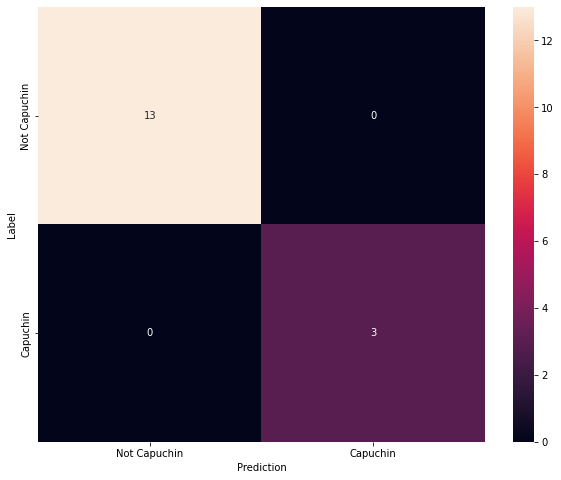

In [107]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=["Not Capuchin", "Capuchin"],
            yticklabels=["Not Capuchin", "Capuchin"],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# 10 Making Preduction on Forest Recordings

**Challanges:**

1.   As these recording are in mp3 format we have to chnage our load preprocess functions
2.   Convert 3min Audio into 3sec windows as our model is trained on 3sec audio clips
3.   Group the predictions of single clips




## 10.1 Load MP3s

In [108]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

## 10.2 Build Function to Convert Clips into Windowed Spectrograms

In [109]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 10.3 Convert Longer Clips into Windows and Make Predictions

In [110]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)

## 10.4 Combining all the functions and making predictions

In [111]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    y_pred = model.predict(audio_slices)
    
    results[file] = y_pred

In [ ]:
results

## 10.5 Convert Predictions into Classes

In [ ]:
# +ve only on 0.99% accuracy
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

## 10.6 Group Consecutive Detections

In [123]:
from itertools import groupby

filename = []
Capuchinbird_Calls = []
for file, scores in class_preds.items():
    filename.append(file)
    Capuchinbird_Calls.append(tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy())

In [129]:
df_results = pd.DataFrame({'File Name': filename, 'Capuchinbird_Calls':Capuchinbird_Calls}).sort_values(by= ['File Name'])
df_results

,File Name,Capuchinbird_Calls
78,recording_00.mp3,5
85,recording_01.mp3,0
90,recording_02.mp3,0
48,recording_03.mp3,0
40,recording_04.mp3,4
...,...,...
75,recording_95.mp3,5
39,recording_96.mp3,1
94,recording_97.mp3,4
11,recording_98.mp3,17


In [130]:
df_results.to_csv("Forest Recording Predictions.csv", index=False)

# END